In [41]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
# import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 

import sys 
sys.path.append('./src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from SPANVAL import SPANVAL
import DShap
from LOO import LOO
from sklearn.utils.class_weight import compute_class_weight
from utils import load_data, get_filtered_scores
import warnings
from Estimator import Estimator
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data 

In [22]:
x_train, y_train, x_valid, y_valid, x_test, y_test, exog_noise, endog_noise, kwargs = load_data(dataset     = 'adult', 
                                                                                                train_num   = 1000, 
                                                                                                valid_num   = 400, 
                                                                                                exog_noise  = 0., 
                                                                                                endog_noise = 0.2, 
                                                                                                lincs_dir   = './data/processed/',
                                                                                                save_dir    = './data/example/', 
                                                                                                clean_up    = True)

print('train size:', x_train.size(), y_train.size())                                                                                        
print('valid size:', x_valid.size(), y_valid.size())                                                                                        
print('test size:', x_test.size(), y_test.size())                                                                                        

train size: torch.Size([1000, 108]) torch.Size([1000, 1])
valid size: torch.Size([400, 108]) torch.Size([400, 1])
test size: torch.Size([15881, 108]) torch.Size([15881, 1])


In [23]:
classes = list(np.sort(np.unique(y_train.detach().numpy())).astype(int))
classes

[0, 1]

# Define Learning Algorithm 

In [29]:
model = NN(in_channels      = x_train.size(1), 
           out_channels     = len(classes), 
           num_layers       = 2, 
           hidden_channels  = 100, 
           norm             = True, 
           dropout          = 0.5, 
           bias             = True, 
           act              = torch.nn.Mish, 
           out_fn           = None)

In [10]:
model.state_dict().keys()

odict_keys(['f.0.weight', 'f.0.bias', 'f.4.weight', 'f.4.bias', 'f.8.weight', 'f.8.bias'])

# Data Shapley (dshap)

[arxiv](https://arxiv.org/abs/1904.02868)  
[proceedings](https://proceedings.mlr.press/v97/ghorbani19c/ghorbani19c.pdf)  
[github](https://github.com/amiratag/DataShapley) 

```
@inproceedings{ghorbani2019data,
  title={Data Shapley: Equitable Valuation of Data for Machine Learning},
  author={Ghorbani, Amirata and Zou, James},
  booktitle={International Conference on Machine Learning},
  pages={2242--2251},
  year={2019}
}
```

In [38]:
CEL = torch.nn.CrossEntropyLoss() 

dshap = DShap.DShap(model           = model, 
                    crit            = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)),
                    x_train         = x_train,
                    y_train         = y_train,
                    x_valid         = x_valid,
                    y_valid         = y_valid,
                    perf_metric     = lambda y, yhat: roc_auc_score(y, yhat[:, 1]),
                    epochs          = 100,
                    tol             = 0.03,
                    optim           = torch.optim.Adam,
                    lr              = 1e-3,
                    verbose         = True)

tic = time.time() 
vals_shap = dshap.TMC(max_iterations=500, min_iterations=50, use_cuda=True, T=5, stopping_criteria=0.999)

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

v0 (null model): 0.5673
vD (all data): 0.8368

starting Data Shapley TMC...
iter: 118 || max j: 347 || max vj: 0.8302 || rank_corr: 0.9988
MC stopping criteria met. running avg rank correlation: 0.9990

time elapsed: 109.85 min


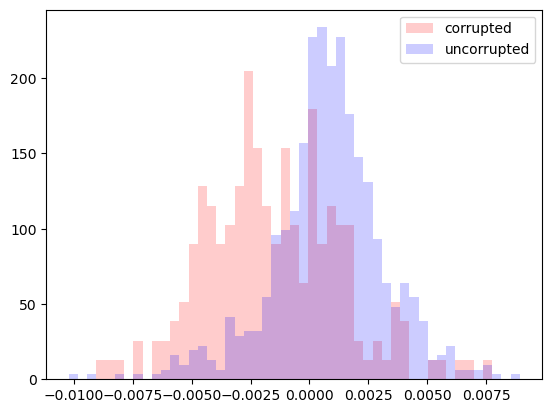

In [ ]:
plt.figure() 
bins = np.linspace(vals_shap.min(), vals_shap.max(), 50)
plt.hist(vals_shap[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_shap[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

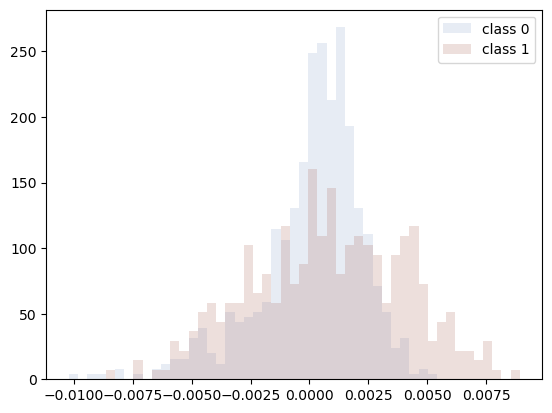

In [ ]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_shap.min(), vals_shap.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_shap[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

[0.005, 0.01, 0.02, 0.025, 0.03, 0.04, 0.05, 0.055, 0.065, 0.065, 0.07, 0.075, 0.085, 0.09, 0.1, 0.11, 0.115, 0.125, 0.13, 0.14, 0.15, 0.155, 0.16, 0.17, 0.18, 0.19, 0.195, 0.205, 0.21, 0.215, 0.22, 0.23, 0.235, 0.24, 0.245, 0.255, 0.265, 0.27, 0.28, 0.285, 0.285, 0.295, 0.3, 0.305, 0.315, 0.325, 0.33, 0.34, 0.35, 0.36, 0.36, 0.365, 0.365, 0.37, 0.37, 0.37, 0.37, 0.38, 0.385, 0.39, 0.395, 0.405, 0.41, 0.415, 0.42, 0.42, 0.42, 0.425, 0.43, 0.43, 0.43, 0.435, 0.435, 0.44, 0.44, 0.445, 0.45, 0.46, 0.46, 0.47, 0.475, 0.475, 0.48, 0.48, 0.48, 0.485, 0.485, 0.49, 0.5, 0.505, 0.51, 0.51, 0.52, 0.52, 0.52, 0.525, 0.53, 0.535, 0.54, 0.55, 0.555, 0.56, 0.56, 0.565, 0.57, 0.57, 0.57, 0.57, 0.575, 0.58, 0.58, 0.58, 0.585, 0.59, 0.59, 0.595, 0.595, 0.6, 0.605, 0.61, 0.615, 0.615, 0.62, 0.62, 0.62, 0.625, 0.625, 0.625, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.635, 0.635, 0.64, 0.64, 0.64, 0.64, 0.64, 0.645, 0.65, 0.65, 0.65, 0.65, 0.65, 0.655, 0.655, 0.655, 0.655, 0.66, 0.665, 0.67, 0.67, 0

/tmp/ipykernel_1681128/607299732.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


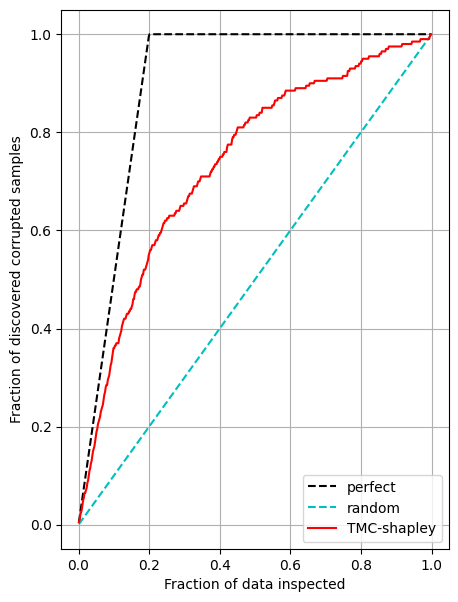

In [39]:
pk, shap_corr, p_perfect, p_random = get_corruption_scores(vals_shap, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)
plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, shap_corr, 'r-', label='TMC-shapley')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

# Leave-one-out (LOO)



In [ ]:
CEL = torch.nn.CrossEntropyLoss() 
crit = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)) 
metric = lambda y,yhat: roc_auc_score(y, yhat[:, 1])  

loo = LOO(x_train           = x_train,
          y_train           = y_train,
          x_valid           = x_valid,
          y_valid           = y_valid,
          model             = model,
          metric            = metric,
          crit              = crit, 
          optim             = torch.optim.Adam, 
          epochs            = 200, 
          lr                = 1e-4,
          batch_size        = 250, 
          use_cuda          = True, 
          verbose           = True, 
          baseline_repl     = 10,
          n_repl            = 1)

print()  

loo_values = loo.run()
vals_loo = np.array(loo_values)

baseline performance: 0.857 +/- 0.001



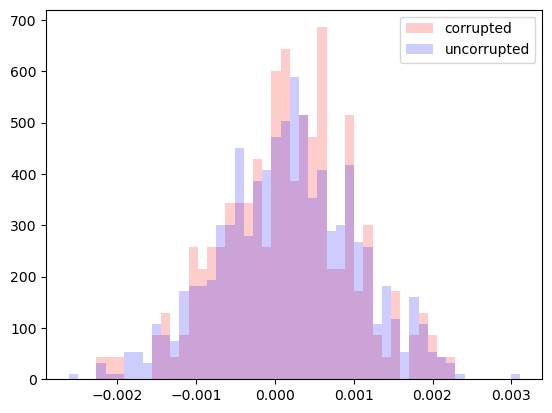

In [ ]:
plt.figure() 
bins = np.linspace(vals_loo.min(), vals_loo.max(), 50)
plt.hist(vals_loo[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_loo[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

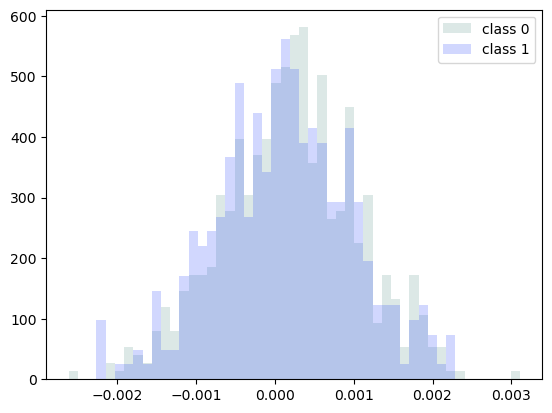

In [ ]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_loo.min(), vals_loo.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_loo[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

In [ ]:
pk, loo_corr, p_perfect, p_random = get_corruption_scores(vals_loo, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, loo_corr, 'r-', label='LOO')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

# Data Valuation with Reinforcement Learning (DVRL)

In [15]:
#pred = LogisticRegression(108, 2) 

pred = copy.deepcopy(model) 
#pred.reset_parameters()

estimator = Estimator(xin               = 108, 
                      yin               = 4, 
                      y_cat_dim         = 10, 
                      num_layers        = 5, 
                      hidden_channels   = 100, 
                      norm              = False, 
                      dropout           = 0., 
                      act               = torch.nn.ReLU)

dvrl = DVRL(x_train             = x_train,
            y_train             = y_train,
            x_valid             = x_valid,
            y_valid             = y_valid,
            predictor           = pred, 
            estimator           = estimator, 
            problem             = 'classification',
            include_marginal    = True)

dvrl_run = { 
                "perf_metric"            : 'auroc', 
                "crit_pred"              : lambda yhat,y: torch.nn.functional.cross_entropy(yhat, y.squeeze(1)), 
                "outer_iter"             : 50, 
                "inner_iter"             : 100, 
                "outer_batch"            : 1000, 
                "inner_batch"            : 256, 
                "estim_lr"               : 1e-2, 
                "pred_lr"                : 1e-3, 
                "fix_baseline"           : True,
                "use_cuda"               : True,
            }

print()

# pretraining...
#dvrl.fit(dvrl.predictor, dvrl.x_train, dvrl.y_train, crit=lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), batch_size=256, lr=1e-4, epochs=500, use_cuda=True)

tic = time.time() 
vals_dvrl = dvrl.run(**dvrl_run, noise_labels=endog_noise)

vals_dvrl = vals_dvrl.detach().numpy().ravel()

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')      


pretraining `ori_model` and `val_model` 
[0.7742293906810036, 0.7768458781362008, 0.7706451612903226]
4/4
ter iteration: 6 || reward: -0.0142 || dvrl perf: 0.7597 || baseline: 0.7739 || noise auc: 0.72|| crpt/tot: 94/491 [0.19] || epoch elapsed: 0.4 souter iteration: 8 || reward: -0.0537 || dvrl perf: 0.7203 || baseline: 0.7739 || noise auc: 0.79|| crpt/tot: 106/505 [0.21] || epoch elapsed: 0.4 souter iteration: 10 || reward: -0.0582 || dvrl perf: 0.7157 || baseline: 0.7739 || noise auc: 0.81|| crpt/tot: 101/516 [0.20] || epoch elapsed: 0.4 souter iteration: 12 || reward: -0.0229 || dvrl perf: 0.7510 || baseline: 0.7739 || noise auc: 0.81|| crpt/tot: 115/541 [0.21] || epoch elapsed: 0.4 souter iteration: 14 || reward: -0.0682 || dvrl perf: 0.7057 || baseline: 0.7739 || noise auc: 0.82|| crpt/tot: 91/478 [0.19] || epoch elapsed: 0.4 souter iteration: 16 || reward: -0.0246 || dvrl perf: 0.7493 || baseline: 0.7739 || noise auc: 0.85|| crpt/tot: 88/502 [0.18] || epoch elapsed: 0.4 souter 

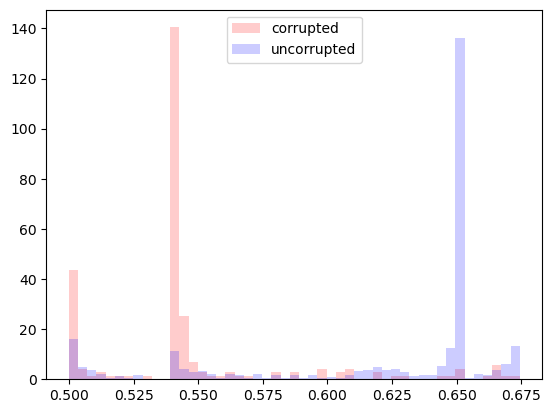

In [26]:
plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvrl[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

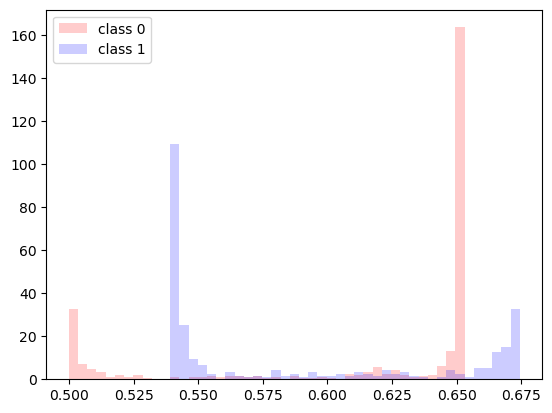

In [28]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 
class_colors = ['r', 'b', 'g', 'y', 'c']

plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_dvrl[class_idx], color=class_colors[c], alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

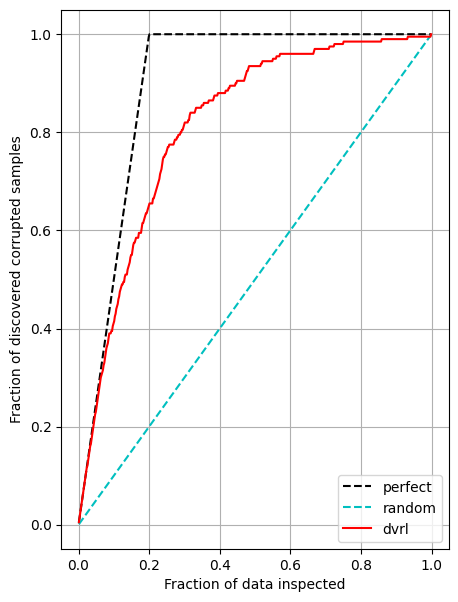

In [16]:
pk, dvrl_corr, p_perfect, p_random = get_corruption_scores(vals_dvrl, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)
plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvrl_corr, 'r-', label='dvrl')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid()
plt.show()

In [44]:
#pred = LogisticRegression(108, 2) 

pred = copy.deepcopy(model).cuda() 
#pred.reset_parameters()
class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=classes, y=y_valid.detach().numpy().ravel()), dtype=torch.float).to('cuda')

CEL_balanced = torch.nn.CrossEntropyLoss(weight=class_weights) 
estimator = Estimator(xin               = 108, 
                      yin               = 4, 
                      y_cat_dim         = 10, 
                      num_layers        = 5, 
                      hidden_channels   = 100, 
                      norm              = False, 
                      dropout           = 0., 
                      act               = torch.nn.ReLU)

VALS = SPANVAL(x_train             = x_train,
            y_train             = y_train,
            x_valid             = x_valid,
            y_valid             = y_valid,
            predictor           = pred, 
            estimator           = estimator, 
            problem             = 'classification',
            include_marginal    = True)

SPANVAL_run = { 
                "crit"              : lambda yhat,y: torch.nn.functional.cross_entropy(yhat, y.squeeze(1)), 
                "target_crit"       : lambda x,y: CEL_balanced(x,y.squeeze(1)),
                "iter"             : 500, 
                "num_epochs"             : 3, 
                "batch"            : 1000, 
                "num_restarts"            : 3, 
                "estim_lr"               : 1e-2, 
                "pred_lr"                : 1e-3, 
                "fix_baseline"           : True,
                "use_cuda"               : True,
            }



tic = time.time() 
vals_MPG = VALS.run(**SPANVAL_run, noise_labels=endog_noise)
vals_mpg = VALS.agg(f'./results/')

# MPG.clean(f'../results/')
print('finished')

 

val_model train finished


/tmp/pycharm_project_323/src/SPANVAL.py:271: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional_with_buffers` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fmodel, params, buffers = make_functional_with_buffers(model)


save_success 0eward: 0.9086 || avg_reward: -0.2966|| mean prob: 0.35 || max prob: 0.52|| min prob: 0.03 || noise auc: 0.84|| crpt/tot: 21/346 [0.06]


/tmp/pycharm_project_323/src/SPANVAL.py:271: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional_with_buffers` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fmodel, params, buffers = make_functional_with_buffers(model)


ter: 22 || reward: 0.7597 || avg_reward: 0.2095|| mean prob: 0.24 || max prob: 0.56|| min prob: 0.01 || noise auc: 0.57|| crpt/tot: 42/216 [0.19]iter: 33 || reward: 0.6141 || avg_reward: 0.3565|| mean prob: 0.36 || max prob: 0.55|| min prob: 0.08 || noise auc: 0.65|| crpt/tot: 64/377 [0.17]iter: 42 || reward: 0.4446 || avg_reward: 0.3977|| mean prob: 0.43 || max prob: 0.57|| min prob: 0.18 || noise auc: 0.75|| crpt/tot: 74/429 [0.17]iter: 52 || reward: 0.4391 || avg_reward: 0.4057|| mean prob: 0.48 || max prob: 0.58|| min prob: 0.32 || noise auc: 0.86|| crpt/tot: 84/501 [0.17]iter: 62 || reward: 0.3764 || avg_reward: 0.3982|| mean prob: 0.49 || max prob: 0.58|| min prob: 0.34 || noise auc: 0.87|| crpt/tot: 85/509 [0.17]iter: 73 || reward: 0.2953 || avg_reward: 0.3970|| mean prob: 0.52 || max prob: 0.60|| min prob: 0.35 || noise auc: 0.87|| crpt/tot: 78/534 [0.15]iter: 84 || reward: 0.6308 || avg_reward: 0.4035|| mean prob: 0.52 || max prob: 0.61|| min prob: 0.33 || noise auc: 0.87|| cr

/tmp/pycharm_project_323/src/SPANVAL.py:271: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional_with_buffers` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fmodel, params, buffers = make_functional_with_buffers(model)


save_success 2eward: -0.4219 || avg_reward: -0.5457|| mean prob: 0.51 || max prob: 0.51|| min prob: 0.50 || noise auc: 0.82|| crpt/tot: 96/491 [0.20]]
finished


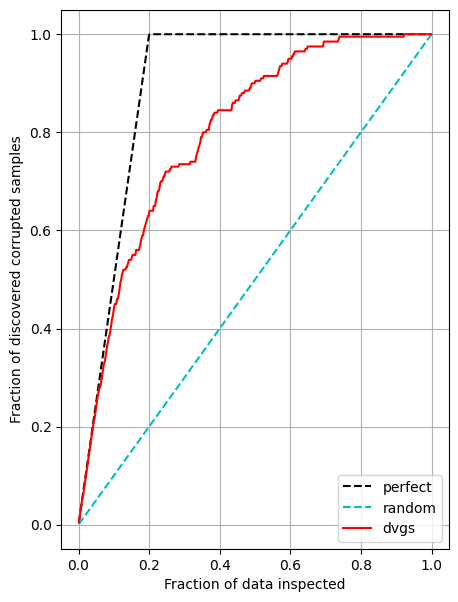

In [43]:

pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(vals_mpg.squeeze(), endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)
plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid()
plt.show()